# Probability and Information Theory

## Steps

1. Understand the problem and the mathematical model and generate data
2. Load the (generated) data and get an overview
3. Try to fit parametric probability distributions
4. Joint  and conditional probabilities, chain rule and Bayes' Theorem
5. Self-entropy of an event and entropy of a distribution

## Understand the problem and the mathematical model and generate data

From [1] we learned the following simplified model for simulating and understanding the spreading of diseases. 

![Epidemic process](img/epidemic_process.png)

A fraction of $\beta$ of the susceptible indivisuals $S$ gets infected each unit of time, say each day. A fraction $\mu$ of the infected recover. A simple generalization is a third parameter $\nu$ and the assumption that only $\nu\mu$ individuals recover, while ${1-\nu}\mu$ individuals die.

This leads to the following system of ordinary differencial equations (ODEs):

\begin{align}
\frac{\delta S}{\delta t} & = -\beta S(t)I(t)\\
\frac{\delta I}{\delta t} & = \beta S(t)I(t) -\mu I(t)\\
\frac{\delta R}{\delta t} & = \nu\mu I(t)\\
\frac{\delta D}{\delta t} & = (1-\nu)\mu I(t)
\end{align}

Given starting values of $S(0)=99, I(0)=1, R(0)=D(0)=0$ and parameter values for $\beta=0.05\%, \mu=1.75\%, \nu=99\%$, we can simulate this system of ODEs.

In `Matlab`, we use the ordinary differencial equation solver `ode45`.

In [122]:
%%file virusSpreading.m
function res = virusSpreading(t, y, beta, mu, nu)
    S=y(1);
    I=y(2);
    R=y(3);
    D=y(4);
    
    res(1,1)=-beta*S*I;
    res(2,1)=beta*S*I-mu*I;
    res(3,1)=nu*mu*I;
    res(4,1)=(1-nu)*mu*I;
end

Overwriting virusSpreading.m


In [123]:
%%file simVirusSpreading.m
function res = simVirusSpreading(beta, verbose)
    S0 =99;
    I0 =1;
    R0 = 0;
    D0 = 0;
    y0 = [S0, I0, R0, D0]';
    t_span = [0 500];
    mu = 0.0175;
    nu = 0.99;
    [tSol, ySol] = ode45(@(t,y) virusSpreading(t, y, beta, mu, nu), t_span, y0);
    if verbose
        plot(tSol, ySol);
        legend("Susceptible","Infected","Recovered","Dead");
    end
    res = [tSol, ySol];
end

Overwriting simVirusSpreading.m


In [124]:
format compact
beta = 0.0005; %0.05%
simVirusSpreading(beta, true);

SyntaxError: invalid syntax (<ipython-input-124-6c312e9a134f>, line 1)

Note that the development highly depends on the parameter $\beta$. So, if all behave well, the infection risk drops and the infection spreading slows down. Inversely, if we misbehave and increase the risk of infection, the infection spreads faster. Here simulations with $\beta = 0.03\%$ and $\beta = 0.07\%$, respectively.

In [ ]:
beta = 0.0003;
simVirusSpreading(beta, true);

In [ ]:
beta = 0.0007;
simVirusSpreading(beta, true);

Of course, the exact parameters values for $\beta, \mu, \nu$ are not known but can only be approximated from observations. The ODE model is an abstraction of the real process, which depends on deterministic but unknown variables and randomness. Therefore, it makes sense to understand disease spreading as a **random process.**

We will generate some observations from this process from different countries and then forget about the process and only work with the observations.

Therefore, we assume that $\beta$ distributes normally around a mean of $\bar \beta = 0.05\%$ with a standard deviation of $\sigma = 0.01\%$. We generate the data for $50$ countries. However, we are only "observing" $8$ new features.

1. The numbers $N_{50}, N_{150}, N_{300}$ of infected after $50, 150, 300$ days, resp. 
2. The corresponding numbers of new infections on that day $D_{50}, D_{150}, D_{300}$.
3. The time $T_{peak}$ to peak infection.
4. The total number of casulties $X_{500}$ after $500$ days.

In [ ]:
countries = 150;
verbose = false;
export_raw_data = true;
if verbose
    countries=1;
end
if export_raw_data
    raw_features = zeros(4*countries, 501);
    raw_features(1,:) = 1:501;
end
features = zeros(countries,8);
rng('default')  % For reproducibility
betas = normrnd(0.0005,0.0001,[1,countries]);
for i=1:countries
    res = simVirusSpreading(betas(i), false);
    times = res(:,1);
    % Add randomness to the observations
    rand_res = zeros(size(res,1),5);
    rand_res(:,1) = times;
    for j=2:5
        rand_res(:,j) = arrayfun(@(x) normrnd(0,0.025*x)+x, res(:,j));
    end
    if verbose
        fprintf("Beta = %.3f%%\n",betas(1)*100);
        plot(times,[res(:,2) rand_res(:,2), res(:,3) rand_res(:,3),res(:,4) rand_res(:,4),res(:,5) rand_res(:,5)]);        
    end
    if export_raw_data
        days = [0:500];
        for var = 2:5
            F = griddedInterpolant(rand_res(:,1),rand_res(:,var));
            raw_features((i-1)*4+var,:)=F(days);
        end
    end
    ti = times(times<=50);
    n_50 = rand_res(length(ti),3);
    d_50 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    ti = times(times<=150);
    n_150 = rand_res(length(ti),3);
    d_150 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    ti = times(times<=300);
    n_300 = rand_res(length(ti),3);
    d_300 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    [M,ii] = max(rand_res(:,3));
    t_peak = times(ii);
    if verbose
        fprintf("n_50=%.4f, n_150=%.4f, n_300=%.4f\nd_50=%.4f, d_150=%.4f, d_300=%.4f\nt_peak=%.4f\nx_500=%.4f\n",n_50, n_150, n_300, d_50, d_150, d_300, t_peak, rand_res(end,5) );
    end
    features(i,:)=[n_50, n_150, n_300, d_50, d_150, d_300, t_peak, rand_res(end,5)];
end
writematrix(features,'../2020 DL data/epidemic_process.csv');
if export_raw_data
    writematrix(raw_features,'../2020 DL data/epidemic_process_raw_data.csv');
end

## Load the (generated) data and get an overview

This is your starting point. Load the observation data.

In [126]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [127]:
# Load Data
features = np.loadtxt('data/epidemic_process.csv', delimiter=",");

In [128]:
# Explore data
print(features.shape)

(150, 8)


Plot the emperical **cumulative probability distributions** (CDFs) of the **random variables** (features).

[[ 5.63613814 33.93921594]
 [ 8.49717798 34.71485141]
 [ 1.51471644  3.41007954]
 [ 5.79222116 34.20190064]
 [ 4.3371902  29.67548195]
 [ 2.13603668 10.63005914]
 [ 3.10787733 21.50810275]
 [ 5.33800546 31.43994107]
 [18.11954008 26.2503158 ]
 [11.78243953 29.29343219]
 [ 2.20933423  9.95899121]
 [16.615508   28.22635267]
 [ 5.7296911  33.36831016]
 [ 3.97763382 24.8667954 ]
 [ 5.94039476 35.03384716]
 [ 4.23325129 25.36102771]
 [ 4.26005681 24.82794859]
 [ 8.23151179 35.6799642 ]
 [ 7.9170733  33.7063959 ]
 [ 7.77724547 33.93852125]
 [ 5.82016381 32.81584812]
 [ 2.1821851  10.49374626]
 [ 5.62252599 32.34440896]
 [ 8.0645793  32.78950957]
 [ 5.7577195  31.4652778 ]]
[[ 1.09452765  1.36186946]
 [ 1.51471644  3.41007954]
 [ 1.67840382  4.25172343]
 [ 1.68147184  4.63684726]
 [ 1.69465244  5.02828137]
 [ 1.72808216  5.26835261]
 [ 1.76810308  5.36353826]
 [ 1.88234347  6.40087946]
 [ 1.90556814  6.70363775]
 [ 1.98830258  7.13642889]
 [ 2.04586464  8.32825078]
 [ 2.10038022  8.66879502]


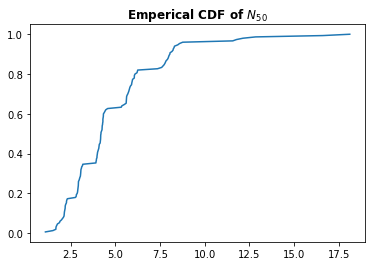


Stats:
min: 1.36186946138486 
max: 36.180054801042 
mean: 24.304010844479254 
median: 26.552072361229698 
std: 9.369317963261611


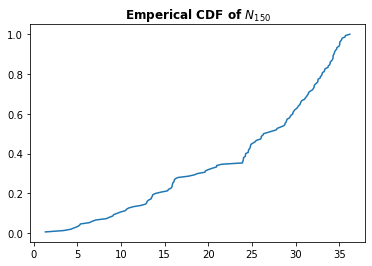


Stats:
min: 1.85343577820181 
max: 15.4489379441267 
mean: 9.094517264052822 
median: 8.56918436577261 
std: 3.6103587132371135


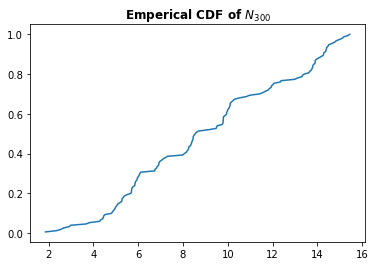


Stats:
min: -0.0350015454900432 
max: 4.27279803177454 
mean: 0.9860369808221754 
median: 0.8444459099534496 
std: 0.6543869789641513


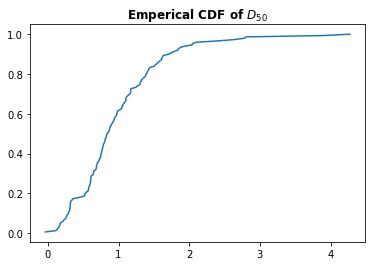


Stats:
min: -5.04053033697628 
max: 3.82098523439884 
mean: 0.8094628725207003 
median: 1.3612538888961851 
std: 2.024392099427704


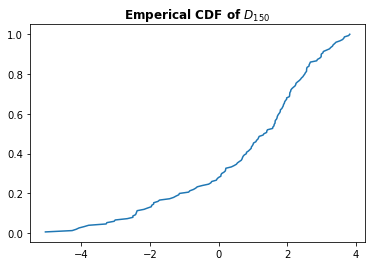


Stats:
min: -2.64402083643261 
max: 0.863244930108102 
mean: -1.1996745738866572 
median: -1.23720951872533 
std: 0.5995884365046847


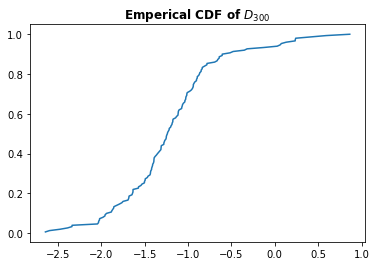


Stats:
min: 86.1405393434167 
max: 472.652648545977 
mean: 175.29100886142976 
median: 163.107655619219 
std: 55.87888026714146


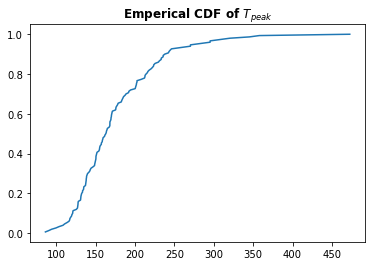


Stats:
min: 0.144004825211393 
max: 1.03678011096662 
mean: 0.8897988109436606 
median: 0.9151311055938649 
std: 0.1136984417004782


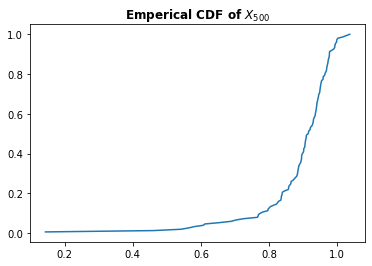

In [141]:
#[h,stats] = cdfplot(features(:,1));
#title("Emperical CDF of N_{50}")
#stats

#s = np.sort(np.random.rand(10,2),axis=0)
s = np.sort(features,axis=0)
print(features[0:25,0:2])
print(s[0:25,0:2])
minvals = s[0,:]
maxvals = s[len(s)-1,:]
meanvals = np.mean(s,axis=0)
medianvals = np.median(s,axis=0)
stdvals = np.std(s,axis=0)
#print("\nsorted\n",s)
# print("\nminval\n",minvals)
# print("\nmaxval\n",maxvals)
# print("\nmeanvals\n",meanvals)
# print("\nmedianvals\n",medianvals)
# print("\nstdvals\n",stdvals)
#print(np.arange(1,len(s)+1))
#print(np.sort(s,axis=0))

title = "Emperical CDF of "
titles = [ '$N_{50}$','$N_{150}$','$N_{300}$','$D_{50}$', '$D_{150}$','$D_{300}$','$T_{peak}$','$X_{500}$']

for cols in range(s.shape[1]):
    print("\nStats:\nmin:",minvals[cols],"\nmax:",maxvals[cols],"\nmean:",meanvals[cols],"\nmedian:",medianvals[cols],"\nstd:",stdvals[cols])
    plt.title(title + titles[cols],fontweight='bold')
    plt.plot(s[:,cols],np.arange(1,s.shape[0]+1)/s.shape[0])
    plt.show()

Recall, the sample `mean` value is an approximation of the expected value, or **expectation** of the random variable. The sample **variance** is the square of the sample standard deviation `std`.    

Check the correlation between the features.

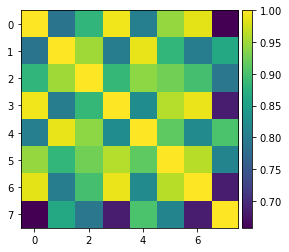

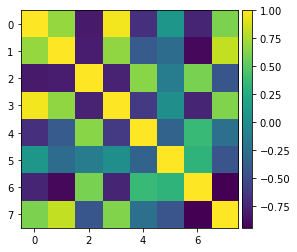

In [143]:
rho = np.corrcoef(s,rowvar=False);
ax = plt.subplot(111)
im = ax.imshow(rho)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()


rho = np.corrcoef(features,rowvar=False);
ax = plt.subplot(111)
im = ax.imshow(rho)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

Recall, the (sample) correlation of two (samples of) random variables $X$ and $Y$ their (sample) **covariance** normalized (divided) by the product of their (sample) standard deviation.

*Discuss your findings. Your answer goes here.*

## Try to fit parametric probability distributions

We go through a set of common probability distributions and try to fit any of them  to the data. We use the Chi-square and the Kolmogorov-Smirnov tests to check the goodness of fit. 

*Note that fitting and testing using the same data is actually not quite correct. We should use cross-validation.*

In [ ]:
%%file distribution_fitting.m
function pd = distribution_fitting(feature)
    distnames =["Poisson", "Exponential", "Gamma", "ExtremeValue", "Kernel"];
    values_must_be_positive =["Poisson", "Exponential", "Gamma"];
    x=feature.';
    x_values = linspace(min(x),max(x));
    for dn=distnames
        if min(x)<0 & ~isempty(find(strcmp(dn, values_must_be_positive)))
          continue;
        end
        distname = char(dn);
        pd = fitdist(x.',distname);
        res1=kstest(x, 'CDF', pd); 
        res2=chi2gof(x, 'CDF', pd);
        if (~res1 && ~res2)
            fprintf('%s with 5%% significance level\r',distname);
            cdfplot(x)
            hold on
            plot(x_values,cdf(pd,x_values),'r-')
            plot(x_values,pdf(pd,x_values),'g-')
            legend('Empirical CDF',[distname ' CDF'],[distname ' PDF'],'Location','best');
            %title(['Empirical CDF and ', [distname ' CDF/PDF']);
            hold off 
            return;
        else 
            fprintf('Not %s with 5%% significance level\n',distname);
        end
    end
end

In [ ]:
pd_n_50 = distribution_fitting(features(:,1))

In [125]:
pd_n_150 = distribution_fitting(features(:,2))

SyntaxError: invalid syntax (<ipython-input-125-c630299b5028>, line 1)

In [ ]:
pd_n_300 = distribution_fitting(features(:,3))

In [ ]:
pd_d_50 = distribution_fitting(features(:,4))

In [ ]:
pd_d_150 = distribution_fitting(features(:,5))

In [ ]:
pd_d_300 = distribution_fitting(features(:,6))

In [ ]:
pd_t_peak = distribution_fitting(features(:,7))

In [ ]:
pd_x_500 = distribution_fitting(features(:,8))

*Describe the fitted distributions. Your answer goes here.*

## Joint  and conditional probabilities, chain rule and Bayes' Theorem

Lets calculate the probability of having a mild start and a disastrous end of the epidemia. We translate that to the **joint probability** that no more than $4\%$ are infected after $50$ days, i.e., $N_{50}\leq 4\%$ and more than $0.95\%$ die in the end, i.e., $X_{500}>0.95\%$.

In [ ]:
n_50 = features(:,1);
x_500 = features(:,8);
positive_cases = length(intersect(find(n_50<=4),find(x_500>0.95)))
all_cases = length(features);
P = positive_cases/all_cases

So $P(N_{50}\leq 4\%, X_{500}>0.95\%) \approx 0.02$.

We check the product of the two probabilities $P(N_{50}\leq 4\%)P(X_{500}>0.95\%)$:

In [ ]:
P2 = length(find(n_50<=4))/all_cases * length(find(x_500>0.95))/all_cases

We are not surprised that the result is different from the joint probability as the random variables $N_{50}$ and $X_{500}$ not independent (double-check the results from the correlation analysis).  

What is the **conditional probability** of more than $0.95\%$ die in the end given that we know that no more $4\%$ are infected after $50$ days.

In [ ]:
mild_start_cases = length(find(n_50<=4));
P_AB = positive_cases/mild_start_cases

So $P(X_{500}>0.95\%|N_{50}\leq 4\%) \approx 0.0588$.

The product or **chain rule** of probability states that

\begin{align}
P(A,B) &= P(A|B)P(B)\\
P(X_{500}>0.95\%,N_{50}\leq 4\%) &= P(X_{500}>0.95\%|N_{50}\leq 4\%)P(N_{50}\leq 4\%)
\end{align}

And we don't get disappointed:

In [ ]:
P_B = mild_start_cases/all_cases;
P = P_AB*P_B

Let us numerically confirm **Bayes' Theorem** for this case. We'd expect that  

\begin{align}
P(A|B) &= \frac{P(B|A)P(A)}{P(B)}\\
P(X_{500}>0.95\%|N_{50}\leq 4\%) &= \frac{P(N_{50}\leq 4\%|X_{500}>0.95\%)P(X_{500}>0.95\%)}{P(N_{50}\leq 4\%)}
\end{align}

And we don't get disappointed:

In [ ]:
disaster_cases = length(find(x_500>0.95));
P_A = disaster_cases/all_cases;
P_BA = positive_cases/disaster_cases;
P_AB = P_BA*P_A/P_B

So far, we have looked at the joint (sample) probability of $P(N_{50}\leq n, X_{500}>x)$ for *concrete* bounds $n=4$ and $x=0.95$. Let us now understand the joint (sample) probability of $F(n,x)=P(N_{50}\leq n, X_{500}>x)$ as a *function* of these bounds $n$ and $x$. Since, $0\leq X_{500}\leq 100$ this function is equal to joint (sample) cumulative distribution function: 

\begin{align}
F(n,x) &=\mathit{CDF}_{N_{50},100-X_{500}}(n,100-x)\\
\mathit{CDF}_{N_{50},100-X_{500}}(n,y)&=P(N_{50}\leq n, 100-X_{500}\leq y)
\end{align}

In `Matlab`, we can numerically approximate such a joint $\mathit{CDF}_{X,Y}(x,y)$:

In [ ]:
addpath('/Users/wlomsi/Documents/MATLAB/ecdfbiv');
joint_CDF=ecdfbiv([n_50, 100-x_500],20,20);
surfc([1:20],[1:20],joint_CDF);

*Interprete this CDF. Your answer goes here.*

Finally, we compare the emperical PDF the (sample) distribution with the fitted PDF of that distribution. We look at $N_{50}$.

In [ ]:
%%file samplePDF.m
function PDF = samplePDF(sample, pd_fit, verbose)
    [f,xi] = ksdensity(sample); 
    PDF = griddedInterpolant(xi,f);
    if (verbose)
        figure
        plot(xi, PDF(xi));
        hold on;
        plot(xi, pdf(pd_fit,xi));
    end
end

In [ ]:
PDF_n_50 = samplePDF(n_50,pd_n_50, true)

In [ ]:
PDF_x_500 = samplePDF(x_500,pd_x_500, true)

## Self-entropy of an event and entropy of a distribution

We define a function that calculates the entropy of a sample distribution, based on a parameterless sample PDF approximation (calculated with `samplePDF`) and a well-known ditribition with fitted parameters (calculated with `distribution_fitting`). It also computeas the Kullback-Leibler (KL) divergence in both directions.

In [ ]:
%%file fit_sample_entropies.m
function [EntropyFitted, EntropySample, diff_fit_sample, diff_sample_fit] = fit_sample_entropies(sample, pd_fit, PDF)
    EntropyFitted = 0;
    EntropySample = 0;
    diff_fit_sample = 0;
    diff_sample_fit = 0;
    for i=1:length(sample)
        EntropyFitted = EntropyFitted - pdf(pd_fit,sample(i))*log(pdf(pd_fit,sample(i)));
        EntropySample = EntropySample - PDF(sample(i))*log(PDF(sample(i)));
        diff_fit_sample = diff_fit_sample - pdf(pd_fit,sample(i))*(log(pdf(pd_fit,sample(i)))-log(PDF(sample(i))));
        diff_sample_fit = diff_sample_fit - PDF(sample(i))*(log(pdf(pd_fit,sample(i)))-log(PDF(sample(i))));
    end
end

Let's apply this function on the $N_{50}$ sample.

In [ ]:
[EntropyFitted, EntropySample, diff_fit_sample, diff_sample_fit] = fit_sample_entropies(n_50, pd_n_50, PDF_n_50)

*Why is the entropy of $N_{50}$ assuming is proportional to the sample PDF higher that assuming it is proportional to the fitted Gamma distribution? Why are the divergence values different? Your answers go here.* 

## References

1. Amira Rachah and Delfim F. M. Torres: Mathematical Modelling, Simulation, and Optimal Control of the 2014 Ebola Outbreak in West Africa. Discrete Dynamics in Nature and Society, Volume 2015, Article ID 842792, https://www.hindawi.com/journals/ddns/2015/842792/.